In [1]:
from firecloud import fiss
import pandas as pd
pd.set_option('display.max_row', 10000)
import io
import numpy as np
from pprint import pprint

In [2]:
%%capture
! pip install plotly

In [3]:
## start hail context
from hail import *
hc = HailContext(sc)

Running on Apache Spark version 2.0.2
SparkUI available at http://10.128.0.3:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-6f85985


In [4]:
samples_sets = fiss.fapi.get_entities('topmed-shared','topmed-shared', 'sample_set').json()
print 'Sample set name:', samples_sets[0]['name']
print 'Sample set fields:', ', '.join(samples_sets[0]['attributes'].keys())


Sample set name: freeze5b_minDP10
Sample set fields: wgsa_subset, gds, vcf, bcf, tbi, cov_grm, samples, wgsa_raw, cor_grm


In [19]:
#https://portal.firecloud.org/#workspaces/topmed-shared/topmed-shared/monitor/121627f8-4a22-475e-9ce3-16214a2607dc/475a4382-ad55-48f4-9e13-ce5436d472a4
# TOPMed JHS subset
vcf_files = ["gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-6/JHS.vcf.bgz",
             "gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-9/JHS.vcf.bgz",
             "gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-10/JHS.vcf.bgz",
             "gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-12/JHS.vcf.bgz",
            "gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-13/JHS.vcf.bgz",
            "gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-14/JHS.vcf.bgz"]


For analysis, we will want to combine genotype data in several different ways -- and these will be specific to each working group. One of the first operations will be to subset the data to a set of cohorts in the T2D analysis.

Taking a look at the top of this data frame:

In [20]:
vds = hc.import_vcf(vcf_files,min_partitions = 120).split_multi()

2017-11-30 03:34:17 Hail: INFO: No multiallelics detected.
2017-11-30 03:34:18 Hail: INFO: Coerced sorted dataset
2017-11-30 03:34:18 Hail: WARN: called redundant split on an already split VDS


In [21]:
vds.summarize().report()


         Samples: 697
        Variants: 74014035
       Call Rate: 0.990392
         Contigs: ['chr22', 'chr19', 'chr15', 'chr18', 'chr20', 'chr21']
   Multiallelics: 0
            SNPs: 66200339
            MNPs: 0
      Insertions: 2816030
       Deletions: 4997666
 Complex Alleles: 0
    Star Alleles: 0
     Max Alleles: 2


In [22]:
vds = vds.variant_qc().cache()

Filter to variants that have MAC>0 in this sample.

In [23]:
vds_subset_one_group = vds.filter_variants_expr('va.qc.AC>0').repartition(120)

In [ ]:
vds_subset_one_group.summarize().report()

LD prune - make new data set

In [ ]:
vds_result = (vds_subset_one_group.variant_qc()
              .filter_variants_expr("va.qc.AF >= 0.05 && va.qc.AF <= 0.95")
              .ld_prune().repartition(120))

2017-11-30 03:50:26 Hail: INFO: Running LD prune with nSamples=697, nVariants=1946800, nPartitions=120, and maxQueueSize=298262.
2017-11-30 03:52:29 Hail: INFO: LD prune step 1 of 3: nVariantsKept=437671, nPartitions=120, time=2m3.4s
2017-11-30 04:01:51 Hail: INFO: LD prune step 2 of 3: nVariantsKept=434900, nPartitions=3, time=9m21.8s
2017-11-30 04:44:34 Hail: INFO: Coerced sorted dataset


In [32]:
vds_result.summarize().report()


         Samples: 697
        Variants: 434899
       Call Rate: 0.940610
         Contigs: ['chr22', 'chr19', 'chr15', 'chr18', 'chr20', 'chr21']
   Multiallelics: 0
            SNPs: 296852
            MNPs: 0
      Insertions: 71073
       Deletions: 66974
 Complex Alleles: 0
    Star Alleles: 0
     Max Alleles: 2


## Running PCA on Freeze 5b Genotypes

In [33]:
# do pca
pca = vds_result.pca('sa.pca', k=5, eigenvalues='global.eigen')

2017-11-30 05:48:10 Hail: INFO: Running PCA with 5 components...


In [34]:
pca_table = pca.samples_table().to_pandas()

### Visualize the differences in families within the studies by principle components.

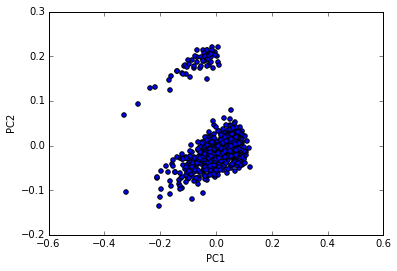

In [35]:
# show the pca results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline

plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"])

plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

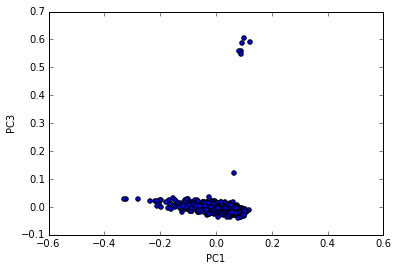

In [36]:
# show the pca results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline

plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC3"])

plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.show()

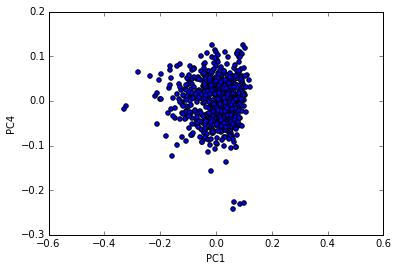

In [37]:
# show the pca results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline

plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC4"])

plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC4")
plt.show()